# Multilayer Perceptron (MLP)

The purpose of this notebook is to practice implementing the multilayer perceptron (MLP) model from scratch, focussing a regression task.

The MLP is a type of neural network model that composes multiple affine transformations together, and applying pointwise nonlinearities in between. Equations for the hidden layers' activations $\mathbf{h}^{(l)}\in\mathbb{R}^{n_l}$, $l=0,1,...,N_L$ ($N_L$ being the number of hidden layers in the MLP), and the output $\hat{\mathbf{y}}\in\mathbb{R}^{n_{N_{L}+1}}$ are given in the following:

$$
\begin{align}
\mathbf{h}^{(0)} &:= \mathbf{x},\tag{1}\\
\mathbf{a}^{(l)} &=  \mathbf{W}^{(l-1)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l-1)},\tag{2}\\
\mathbf{h}^{(l)} &= \sigma( \mathbf{a}^{(l)}),\qquad l=1,\ldots, N_L,\tag{3}\\
\mathbf{\hat{y}} &= \sigma_{out}(\mathbf{a}^{(N_{L}+1)}) = \sigma_{out}\left( \mathbf{W}^{(N_L)} \mathbf{h}^{(N_L)} + \mathbf{b}^{(N_L)} \right),\tag{4}
\end{align}
$$

where $\mathbf x\in\mathbb{R}^p$ is the input vector, $\mathbf{W}^{(l)}\in\mathbb{R}^{n_{l+1}\times n_{l}}$ are the weights, $\mathbf{b}^{(l)}\in\mathbb{R}^{n_{l+1}}$ are the biases, $\sigma, \sigma_{out}: \mathbb{R}\mapsto\mathbb{R}$ are activation functions that operate element-wise, $n_l$ is the number of units in the $l$-th hidden layer, and we have set $n_0 := p$. Moreover, $\mathbf{a}^{(l)}$ is called the pre-activation and $\mathbf{h}^{(l)}$ the post-activation (or activation) of layer $l$.

#### Test Cases

Some of the tasks in this notebook are followed by cells that you can use to verify your solution, to help you in the intermediate steps of this construction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Imports used for testing
import numpy.testing as npt

# Initialise random number generator
rng = np.random.default_rng(2)

# We set a global configuration for matplotlib to obtain well-readable plots
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 1. Data preprocessing

In this notebook we will use the California Housing data, which you have already seen in week 2 (kNN notebook).

In [2]:
# load California Housing data
X = np.load('california_housing_X.npy')
y = np.load('california_housing_y.npy')

**Data Set Characteristics:**

Number of Instances: 20640

Number of Attributes: 8 numeric, predictive attributes and the target

Attribute Information:
- MedInc:        median income in block group
- HouseAge:      median house age in block group
- AveRooms:      average number of rooms per household
- AveBedrms:     average number of bedrooms per household
- Population:    block group population
- AveOccup:      average number of household members
- Latitude:      block group latitude
- Longitude:     block group longitude

Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surprisingly large values for block groups with few households
and many empty houses, such as vacation resorts.

References

- Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
  Statistics and Probability Letters, 33 (1997) 291-297

As usual, we create a train and test split of the data.

In [3]:
# shuffling the rows in X and y
p = rng.permutation(len(y))
Xp = X[p]
yp = y[p]

# we split train to test as 80:20
split_rate = 0.8
X_train, X_test = np.split(Xp, [int(split_rate*(Xp.shape[0]))])
y_train, y_test = np.split(yp, [int(split_rate*(yp.shape[0]))])

With neural network architectures, it is rather common to standardise the data, so we do it also here. It is important to standardise *after* applying the train-test split to prevent any information leakage from the test set into the train set, which can lead to over-optimistic results and unrealistic performance evaluations.

In [4]:
## EDIT THIS FUNCTION
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

In [5]:
# standardise train and test data
X_test = standardise(X_test, X_train_= X_train)
X_train = standardise(X_train)

## 2. Implementation of MLP with 3 hidden layers

Now you should implement an MLP regression model in numpy. The model will have three hidden layers with 64 neurons each, and using a ReLU activation function. The final output layer will be a single neuron with no activation function to predict the target variable $y$.

The building block of the model is the dense (or fully-connected) layer. The following function should implement the affine transformation of this layer, given weights and bias parameters and the input to the layer. It should return the layer pre-activations (no activation function).

In [6]:
## EDIT THIS FUNCTION
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in is the input dimension.
        W (np.ndarray): h_out x h_in array for weights matrix parameters, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X]) ## <-- SOLUTION
    return a

The hidden layers of our model will use a *ReLU* activation function, given by:

$$\sigma_{\mathrm{ReLU}}(x)=\max(0,x)\tag{5}$$

In the following cell, you should implement the *ReLU* activation and its gradient, which will be required in the backpropagation of the MLP.

In [7]:
## EDIT THIS FUNCTION
def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.maximum(a, 0.)  ## <-- SOLUTION
    return h

## EDIT THIS FUNCTION
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = np.zeros_like(a) ## <-- SOLUTION
    grad[a>0] = 1 ## <-- SOLUTION
    return grad

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Weights $\mathbf{W}^{(0)} \in\mathbb{R}^{64 \times 8}$
* Bias $\mathbf{b}^{(0)} \in\mathbb{R}^{64}$

Hidden layer -> hidden layer:
* Weights $\mathbf{W}^{(l)} \in\mathbb{R}^{64\times 64}$, $l=1, 2$
* Bias $\mathbf{b}^{(l)} \in\mathbb{R}^{64}$, $l=1, 2$

Hidden layer -> output layer:
* Weights $\mathbf{W}^{(3)} \in\mathbb{R}^{1 \times 64}$
* Bias $\mathbf{b}^{(3)} \in\mathbb{R}^{1}$

We will create these parameters as numpy arrays, and initialise the weights values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros.

In [8]:
# create the parameters using Glorot initialisation
var0 = 2. / (64 + 8)
W0 = rng.normal(size=(64, 8)) * np.sqrt(var0)
b0 = np.zeros(64)

var1 = 2. / (64 + 64)
W1 = rng.normal(size=(64, 64)) * np.sqrt(var1)
b1 = np.zeros(64)

var2 = 2. / (64 + 64)
W2 = rng.normal(size=(64, 64)) * np.sqrt(var2)
b2 = np.zeros(64)

var3 = 2. / (1 + 64)
W3 = rng.normal(size=(1, 64)) * np.sqrt(var3)
b3 = np.zeros(1)

You should use these parameters and your `dense` function to create the MLP model. Remember that the hidden layers of the model should use a ReLU activation, and the output of the model should not use an activation function.

In [9]:
## EDIT THIS FUNCTION
def mlp_3layers(X):
    """MLP with 3 hidden layers and ReLU activation

    Parameters:
        X: K x 8 array of inputs

    Returns:
        y:  K x 1 output array
    """
    if X.ndim == 1:
        # If one example passed, add a dummy dimension for the batch.
        X = X.reshape(1, -1)

    # compose 3-layer MLP
    h = X
    a = dense(h, W0, b0)
    h = relu_activation(a)

    a = dense(h, W1, b1)
    h = relu_activation(a)

    a = dense(h, W2, b2)
    h = relu_activation(a)
    y = dense(h, W3, b3)

    return y

We can now make a prediction with this simple MLP model.

In [10]:
# Get the output of your initialised model
y_hat_train = mlp_3layers(X_train)

In [11]:
mlp_3layers(X_train[100])

array([[0.12206486]])

**Verification:** To verify your implementation of `relu_activation`, `dense`, `standardise`, you should expect the following cells to execute without error messages.

In [12]:
# The two lines shoud verify your implementation of
# relu_activation, dense, and standardise functions.
npt.assert_allclose(mlp_3layers(X_train[10]), 0.15248698)
npt.assert_allclose(mlp_3layers(X_train[100]), 0.12206486)

We also implement two alternative activation functions. The *sigmoid* activation function $\sigma(x)$ is given by:

$$\sigma_{\mathrm{sigmoid}}(x) = \frac{1}{1+\exp(-x)},\tag{6}$$

and the *tanh* activation is given by:

$$\sigma_{\mathrm{tanh}}(x)=\frac{\exp(x)-\exp(-x)}{\exp(x)+\exp(-x)}=\frac{2}{1+\exp(-2x)}-1\tag{7}$$

In the following two cells you need to implement both activation functions and their gradients.

In [13]:
## EDIT THIS FUNCTION
def tanh_activation(a):
    """Tanh activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = 2 / (1 + np.exp(-2*a)) - 1  ## <-- SOLUTION
    return h

## EDIT THIS FUNCTION
def grad_tanh_activation(a):
    """Gradient of Tanh activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = 1 - tanh_activation(a)**2 ## <-- SOLUTION
    return grad

In [14]:
## EDIT THIS FUNCTION
def sigmoid_activation(a):
    """Sigmoid activation function. We implement here a numerically stable version
    where sigmoid(a) = 1/(1+exp(-a)) when a => 0 and sigmoid(a) = exp(a)/(1+exp(a))
    when a < 0.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """

    # handle scalar inputs
    if np.isscalar(a):
        a = np.array([a])

    # determine indices where a is positive or negative
    positive = a >= 0
    negative = ~positive

    # compute sigmoid for positive a
    h = np.empty_like(a, dtype=float)
    h[positive] = 1 / (1 + np.exp(-a[positive]))    ## <-- SOLUTION

    # compute sigmoid for negative a
    exp = np.exp(a[negative])                       ## <-- SOLUTION
    h[negative] = exp / (exp + 1)                   ## <-- SOLUTION

    return h

## EDIT THIS FUNCTION
def grad_sigmoid_activation(a):
    """Gradient of Sigmoid activation function.

    Parameters:
        a: K x h_out array of pre-activations.

    Returns:
        grad: K x h_out gradient array of post-activations.
    """
    # compute gradient
    grad = sigmoid_activation(a) * (1 - sigmoid_activation(a))  ## <-- SOLUTION
    return grad

**Verification:** To verify your implementation of `tanh_activation`, `grad_tanh_activation`, `sigmoid_activation`, and `grad_sigmoid_activation` run the following cell:

In [15]:
### Verification:

# tanh (test against np.tanh)
npt.assert_allclose(tanh_activation(3), np.tanh(3))
npt.assert_allclose(tanh_activation(-3), np.tanh(-3))

# sigmoid
npt.assert_allclose(sigmoid_activation(2.5),  0.9241418199787566)
npt.assert_allclose(sigmoid_activation(-3), 0.04742587317756678)

# gradient of tanh
npt.assert_allclose(grad_tanh_activation(2), 0.07065082485316443)
npt.assert_allclose(grad_tanh_activation(-1), 0.41997434161402614)

# gradient of sigmoid
npt.assert_allclose(grad_sigmoid_activation(2), 0.10499358540350662)
npt.assert_allclose(grad_sigmoid_activation(-1), 0.19661193324148185)

## 3. Implementation of general MLP model



To generalise our code, we write a MLP class where we can choose the number of layers and dimensions flexibly. (For background on object oriented programming in python see for example: https://www.geeksforgeeks.org/python-oops-concepts/.) Our strategy is to define a `layers` attribute that stores all the information on the layers as a list of dictionaries, with keys `"W"` corresponding to the weights $\mathbf{W}^{(l)}\in\mathbb{R}^{n_{l+1}\times n_{l}}$, `"b"` to the biases $\mathbf{b}^{(l)}\in\mathbb{R}^{n_{l+1}}$ and `"activation"` for the activation functions $\sigma^{(l)}: \mathbb{R}\mapsto\mathbb{R}$. Below is an illustration for two layers. You will have to implement a method `add_layer` that adds a layer to to the MLP.

![layers](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/mlp.drawio.svg)

Once the architecture of the MLP is defined one can make predictions by computing a forward pass. You will implement this in the `predict` method of the MLP class, which returns the predication and the all the pre-activations and post-activations in the forward pass (again as a list of dictionaries with keys `"a"` and `"h"` as visualised below). We need the information from the forward pass later for the backpropagation.

![forward-pass](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/mlp-forward.drawio.svg)

We assume here that the output $\mathbf{\hat{y}}$ of the MLP is used for regression, i.e., we set the output activation $\sigma_{out}$ in Eq. (4) to the identity function.

In [16]:
# A lookup table for activation functions by their names.
activation_table = {
    "relu": relu_activation,
    "sigmoid": sigmoid_activation,
    "tanh": tanh_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    "sigmoid": grad_sigmoid_activation,
    "tanh": grad_tanh_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}

class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers (including input and output)."""
        return len(self.layers) + 1 if len(self.layers) > 0 else 0

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The input dimension of the layer.
            out_dim (int): The output dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            # hint: use self.rng.normal()
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)), ## <-- SOLUTION
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), ## <-- SOLUTION
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"]) ## <-- SOLUTION
            activation = activation_table[self.layers[k]["activation"]] ## <-- SOLUTION
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) ## <-- SOLUTION
        # predicted target is output of last layer
        return y_hat, forward_pass

We can now implement the same MLP architecture as before by creating an object from the `MLP` class, initialised with `seed=2`.

In [17]:
mlp = MLP(seed=2)
mlp.add_layer(8, 64)
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 1, "relu")
print("Number of layers (including input and output layer):", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())

Number of layers (including input and output layer): 5
Number of trainable parameters: 8961


**Test Cases** Now we may verify the `MLP` implementation with input examples with expected outputs. If you struggle with getting it through, you can start with simpler test cases. For example, you can start from 1-layer and a toy two dimensional input and test against what you expect by manual derivation.

In [18]:
mlp = MLP(seed=2)
mlp.add_layer(8, 64)
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 1, "relu")


case_input = X_train[:5]
case_expect = np.array([-0.03983787, -0.04034381,  0.14796773, -0.02884643,  0.03103732])
npt.assert_allclose(mlp.predict(case_input)[0].squeeze(), case_expect)

## 4. Backpropagation in MLP

We use the MSE loss function to evaluate the performance of our model. You will implement it in the cell below, together with its gradient.

In [19]:
def mse_loss(y_true, y_pred):
    """Compute MSE-loss

    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )

    Returns:
        loss (float): MSE-loss
    """
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    # Compute MSE loss
    loss = np.mean((y_true - y_pred)**2, keepdims=True) ## <-- SOLUTION
    return loss

In [20]:
def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    # Compute gradient of MSE loss
    grad = 2.0 * (y_pred - y_true) / y_true.size ## <-- SOLUTION
    return grad

**Verification:** Let's test the implemented `mse_loss` and `grad_mse_loss`.



In [21]:
# We will use the same test inputs for mse_loss and grad_mse_loss.
case_input_arg1 = y_train[:5]
case_input_arg2 = np.array([-0.03983787, -0.04034381,  0.14796773, -0.02884643,  0.03103732])

case_expects = 10.791119
npt.assert_allclose(mse_loss(case_input_arg1, case_input_arg2),
                    case_expects, atol=1e-4)

case_expects = np.array([-2.01593915, -1.72533752, -0.34321291, -0.73353857, -0.96758507])
npt.assert_allclose(grad_mse_loss(case_input_arg1, case_input_arg2),
                    case_expects, atol=1e-4)

In order to train our MLP model with stochastic gradient descent (SGD) we need to compute the gradients of all model parameters for a given minibatch. To do so we use the backpropagation algorithm explained in the lecture notes. Below you will implement a `backpropagate` function that returns for each layer the gradients of its weights and biases stored in a list of dictionaries with keys `"W"` and `"b"`. This data structure is visualised in the following:

![backpropagation](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/refs/heads/main/images/mlp-back_7FEB25.drawio.svg)

Note that $\delta^{(3)}_k$ for the output neurons in the illustration above corresponds to the gradient of the MSE loss. In general, you compute: $$\delta^{(N_L)}=\frac{\partial L}{\partial \mathbf{a}^{(N_{L}+1)}},\tag{8}$$
which in this case is equivalent to $\frac{\partial L}{\partial \mathbf{\hat{y}}}$, since we have taken $\sigma_{out}$ in Eq. (4) equal to the identity function.

In [22]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        gradients (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric in the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    gradients = []

    # Initialise delta.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):   # zip iterates through pairs of layers and forward_pass
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."

        # Gradients are average gradients over batch
        gradients.append({"W" : (delta.T @ h) / h.shape[0], # <-- SOLUTION
                          "b" : delta.mean(axis=0)}) # <-- SOLUTION

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)]) # <-- SOLUTION.


    # Return now ordered list matching the layers.
    gradients = list(reversed(gradients))
    return gradients

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3984133441.py:5: SyntaxWarning: invalid escape sequence '\h'
  partial derivative of the loss function w.r.t the predictions $\hat{y}$


**Verification:** Here we conclude our tests for the implemented `MLP` by testing the gradients computed with backpropagation algorithm, which is considered the most delicate part to implement properly.

In [23]:
my_mlp_test = MLP(seed=42)
my_mlp_test.add_layer(8, 3)
my_mlp_test.add_layer(3, 1, "relu")

def test_grads(mlp, X, y):
    y_hat, forward_pass = mlp.predict(X)
    delta_output_test = grad_mse_loss(y, y_hat)
    return backpropagate(my_mlp_test.layers, forward_pass,
                                  delta_output_test)

## Test the last layer gradients with a batch of size one.
grad = test_grads(my_mlp_test, X_train[0], y_train[0])
grad_W1 = grad[1]["W"]
npt.assert_allclose(grad_W1, np.array([[-0.05504819, -3.14611296, -0.22906985]]), atol=1e-4)

# # Test the last layer gradients with a batch of size two
grad = test_grads(my_mlp_test, X_train[0:2], y_train[0:2])
grad_W1 = grad[1]["W"]
npt.assert_allclose(grad_W1, np.array([[-0.01376205, -0.78652824, -0.05726746]]), atol=1e-4)

# Test the first layer bias with the same batch
grad = test_grads(my_mlp_test, X_train[0:2], y_train[0:2])
grad_b0 = grad[0]["b"]
npt.assert_allclose(grad_b0, np.array([ 0.76784506,  0.63125483, -0.95424802]), atol=1e-4)



The implementation of backpropagation can be challenging and we will go through all the steps in the tutorials.

## 5. Training the MLP with mini-batch Stochastic Gradient Descent

After computing the gradients of weights for a minibatch we can update the weights according to the mini-batch SGD algorithm explained in the lecture notes. The `sgd_step` function below implements this for a single minibatch.

In [24]:
def sgd_step(X, y, mlp, learning_rate = 1e-3):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, p).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        updated_layers (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) ## <-- SOLUTION.

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat) ## <-- SOLUTION

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)  ## <-- SOLUTION.

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"] ## <-- SOLUTION.
        b = layer["b"] - learning_rate * grad["b"] ## <-- SOLUTION.
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

To assess the regression performance we also implement the $R^2$ score.

In [25]:
def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

A full training of the parameters over several epochs with SGD is then implemented in the next cell.

In [26]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 1e-3,
        n_epochs=10, minibatchsize=1, seed=42):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (N^{training}, p).
        y_train (np.ndarray): The training data ground-truth, with shape (N^{training}, 1).
        X_test (np.ndarray): The testing data features, with shape (N^{test}, p).
        y_test (np.ndarray): The testing data ground-truth, with shape (N^{test}, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.

    Returns:
        mlp (MLP): MLP object encapuslating the trained MLP model.
        losses_train (np.ndarray): Train losses over epochs.
        losses_tset (np.ndarray): Test losses over epochs.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    for i in range(n_epochs):

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate) ## <-- SOLUTION.

            # update weights and biases of MLP
            mlp.layers = updated_layers ## <-- SOLUTION.

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        loss_train = mse_loss(y_train, y_hat_train).squeeze()
        losses_train.append(loss_train)
        y_hat_test, _ = mlp.predict(X_test)
        loss_test = mse_loss(y_test, y_hat_test).squeeze()
        losses_test.append(loss_test)

        if (i==0) or ((i+1)%(n_epochs//10)==0):
          print(
              f'Epoch {i+1}/{n_epochs}: In-sample error: {loss_train}, Out-of-sample error: {loss_test},'
              f'train R^2: {r2_score(y_train, y_hat_train):.2f}, test R^2: {r2_score(y_test, y_hat_test):.2f}.'
               )

    return mlp, losses_train, losses_test


In the following, train a small MLP model with the following architecture:
- Input: 8 neurons corresponding to features.
- First hidden layer: 16 neurons and ReLu activation.
- Second hidden layer: 8 neurons and Sigmoid activation.
- Third hidden layer: 4 neurons and ReLu activation.
- Ouput: 1 neuron corresponding to target.

Use mini-batch SGD with learning rate 0.05, minibatch size 64 and train the MLP for 50 epochs.

As before we start by creating a new object from the `MLP` class initialised with `seed=2`.

In [27]:
# compile architecture of MLP
mlp = MLP(seed=2)
mlp.add_layer(X_train.shape[1], 16)     ## <-- SOLUTION.
mlp.add_layer(16, 8, "relu")            ## <-- SOLUTION.
mlp.add_layer(8, 4, "sigmoid")          ## <-- SOLUTION.
mlp.add_layer(4, 1, "relu")             ## <-- SOLUTION.
print("Number of layers (including input and output layer):",mlp.n_layers())
print("Number of trainable parameters:",mlp.n_parameters())

# train MLP using SGD
mlp, losses_train, losses_test = sgd(X_train, y_train, X_test, y_test,
                                     mlp, learning_rate = 0.05,
                                     n_epochs=50,
                                     minibatchsize=64)                  ## <-- SOLUTION.

Number of layers (including input and output layer): 5
Number of trainable parameters: 321
Epoch 1/50: In-sample error: 1.51254503002571, Out-of-sample error: 1.470752529217129,train R^2: -0.13, test R^2: -0.13.
Epoch 5/50: In-sample error: 1.08707400475429, Out-of-sample error: 1.0690608189606956,train R^2: 0.19, test R^2: 0.18.
Epoch 10/50: In-sample error: 0.866841474230677, Out-of-sample error: 0.860337160662782,train R^2: 0.35, test R^2: 0.34.
Epoch 15/50: In-sample error: 0.6615682783043222, Out-of-sample error: 0.6648611259451864,train R^2: 0.51, test R^2: 0.49.
Epoch 20/50: In-sample error: 0.5754553431551951, Out-of-sample error: 0.5834683485724244,train R^2: 0.57, test R^2: 0.55.
Epoch 25/50: In-sample error: 0.5461315620438515, Out-of-sample error: 0.5548789537964346,train R^2: 0.59, test R^2: 0.58.
Epoch 30/50: In-sample error: 0.5280135952656769, Out-of-sample error: 0.5374098014610267,train R^2: 0.61, test R^2: 0.59.
Epoch 35/50: In-sample error: 0.5135033374224165, Out-o

We can plot the progress of the training below.

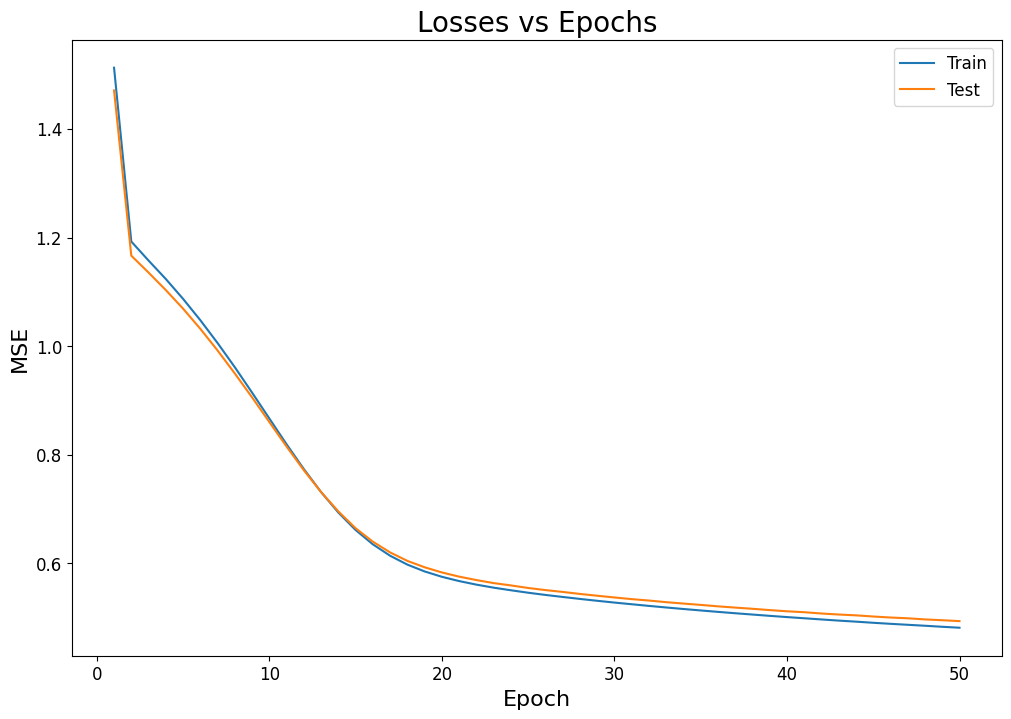

In [29]:
# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,51),losses_train, label="Train")
ax.plot(np.arange(1,51),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

#### Questions
1. How do the training and test losses above compare?
2. Play around with different numbers of hidden layers and number of neurons in the MLP. How is the performance of the model affected?
3. Play around with different activation functions. How is the performance of the model affected?